今回、古典的なサポートベクトルマシーン(SVM)と量子サポートベクトルマシーン(QSVM)モデルを使用して2つのクラスに分類するタスクを実行し、比較しています。ここではコードの概要を説明し具体的なコードの説明はコード内にコメントアウトで記します
- データの生成
  - qiskit_machine_learning.datasetsのモジュールのad_hoc_data関数を使用してデータセットを任意の数値で生成する
- データの可視化
  - 生成されたデータセットをmatplotlibを用いてプロットし、AとBクラスに属するtrain/testデータをの分布を可視化する
- 量子フィーチャーマップ(量子回路の生成)
  - ZZFeatureMapを使用し、通常のコンピュータで扱われるデータを量子データに変換し量子カーネルを用いた機械学習を利用できるようにする
- 古典的SVM(SVC)モデル
  - sklearn.svmモジュールのSVCクラスを使用して、古典的なサポートベクターマシン（SVM）モデルであるsvc_modelを作成する。この古典的なSVMでは、放射基底関数（RBF）カーネルが使用される
    - SVMモデルの学習:
      
      生成されたトレーニングデータセットを用いて学習する
    - SVMモデルのテスト:

      生成されたテストデータセットを用いてSVM分類のテスト精度を評価する
- 量子SVM(QSVM)モデル
  - qiskit_machine_learning.algorithmsモジュールのQSVCクラスを使用して、量子サポートベクターマシン（QSVC）モデルであるqsvc_modelを作成する。また、前に定義された量子フィーチャーマップ（zz_feature_map）を使用する。
    - QSVMモデルの学習:
          
      生成されたトレーニングデータセットを用いて学習する
    - QSVMモデルのテスト:

      生成されたテストデータセットを用いてSVM分類のテスト精度を評価する

- 決定領域の可視化
  - トレーニングデータセットで学習したSVM,QSVMモデルの決定領域を可視化するために決定領域を表す等高線プロットを作成し両者の分類パフォーマンスを比較する



In [88]:
!pip install qiskit[visualization]
!pip install qiskit_machine_learning

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn.svm import SVC
from qiskit import Aer
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.visualization import circuit_drawer
from matplotlib.colors import ListedColormap


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/

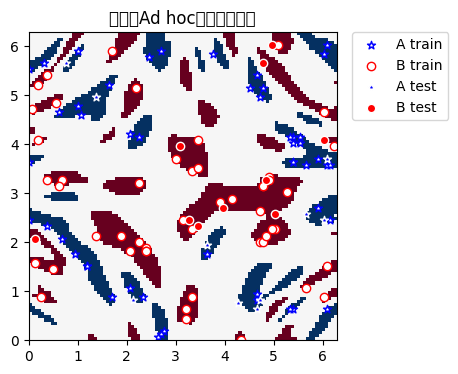

In [93]:
#データの特徴量（2次元）とラベルを受け取り、指定されたクラスのデータポイントをプロットするための関数
def plot_features(plt, features, labels, label_value, marker, facecolor, edgecolor, legend_label):
    plt.scatter(features[np.where(labels[:] == label_value), 0],
                features[np.where(labels[:] == label_value), 1],
                marker=marker, facecolors=facecolor, edgecolors=edgecolor, label=legend_label)


#乱数生成のシード値
seed = 10000
algorithm_globals.random_seed = seed

# ad_hocデータセットを作成
adhoc_dimension = 2 #特徴量の次元数
x_train, y_train, x_test, y_test, adhoc_total = ad_hoc_data(
    training_size=50,              #トレーニングデータサイズ
    test_size=10,                 #テストデータサイズ
    n=adhoc_dimension,          #特徴量の次元数
    gap=0.5,                     #2クラス間の最小距離　この値が大きいほど、クラス同士のデータが離れた領域に生成される
    plot_data=False,             #データセットをプロットしないようにする
    one_hot=False,              #ラベルをone-hotエンコードせず、0と1のラベルで出力するように設定
    include_sample_total=True  #データセットの総数を返すように設定
)

# ad_hocデータセットをプロット
plt.figure(figsize=(4, 4))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
           origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

# A train plot
plot_features(plt, x_train, y_train, 0, "*", "w", "b", "A train")

# B train plot
plot_features(plt, x_train, y_train, 1, "o", "w", "r", "B train")

# A test plot
plot_features(plt, x_test, y_test, 0, "*", "b", "w", "A test")

# B test plot
plot_features(plt, x_test, y_test, 1, "o", "r", "w", "B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("分類用Ad hocデータセット")
plt.show()


In [94]:
# QASMシミュレーターの設定
quantum_instance = Aer.get_backend('qasm_simulator')


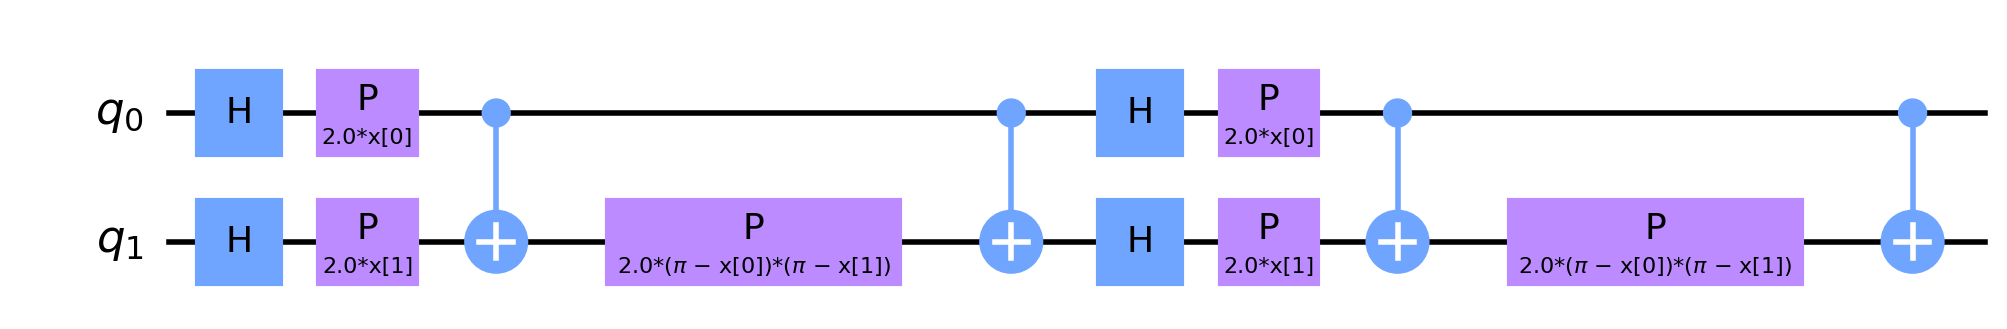

In [95]:
#  量子特徴量マップを使用して量子カーネルを設定
zz_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement='linear')
zz_kernel = QuantumKernel(feature_map=zz_feature_map, quantum_instance=quantum_instance)

zz_feature_map.decompose().draw(output="mpl", scale=2)

In [96]:
# 古典的なSVMモデル（SVC）を作成
svc_model = SVC(kernel='rbf', random_state=seed)

# SVCモデルにフィット
svc_model.fit(x_train, y_train)

# SVCモデルのテスト精度を計算
svc_test_accuracy = svc_model.score(x_test, y_test)

print(f"SVC分類のテスト精度: {svc_test_accuracy:.2f}")

SVC分類のテスト精度: 0.55


In [97]:
# 量子カーネルとQSVCモデルを作成
qsvc_model = QSVC(quantum_kernel=zz_kernel)

# QSVCモデルにフィット
qsvc_model.fit(x_train, y_train)

# QSVCモデルのテスト精度を計算
qsvc_test_accuracy = qsvc_model.score(x_test, y_test)

print(f"QSVC分類のテスト精度: {qsvc_test_accuracy:.2f}")

QSVC分類のテスト精度: 1.00


<ipython-input-98-7a95d18b769c>:36: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
<ipython-input-98-7a95d18b769c>:36: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from current font.
  plt.tight_layout()
<ipython-input-98-7a95d18b769c>:36: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.tight_layout()
<ipython-input-98-7a95d18b769c>:36: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from current font.
  plt.tight_layout()
<ipython-input-98-7a95d18b769c>:36: UserWarning: Glyph 20856 (\N{CJK UNIFIED IDEOGRAPH-5178}) missing from current font.
  plt.tight_layout()
<ipython-input-98-7a95d18b769c>:36: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
<ipython-input-98-7a95d18b769c>:36: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  plt.tight_layout()
<ipython-input

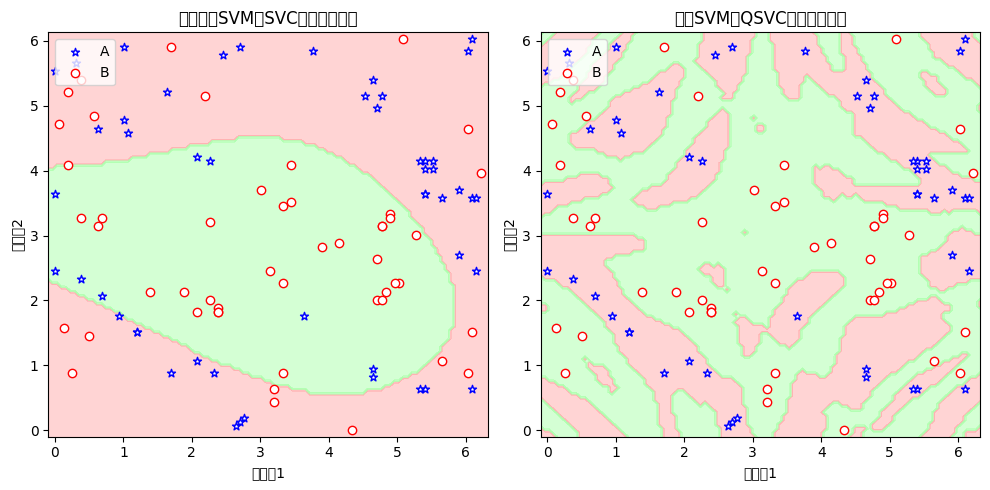

In [98]:
def plot_decision_regions(model, X, y, title):
    cmap = ListedColormap(['#FFAAAA', '#AAFFAA'])

    # 決定領域をプロットするためのメッシュグリッドを作成
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 決定領域をプロット
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

    # データポイントをプロット
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1], marker='*', facecolors='w', edgecolors='b', label='A')
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1], marker='o', facecolors='w', edgecolors='r', label='B')

    plt.xlabel('特徴量1')
    plt.ylabel('特徴量2')
    plt.title(title)
    plt.legend(loc='upper left')

# 古典的なSVM（SVC）の決定領域をプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_decision_regions(svc_model, x_train, y_train, '古典的なSVM（SVC）の決定領域')

# 量子SVM（QSVC）の決定領域をプロット
plt.subplot(1, 2, 2)
plot_decision_regions(qsvc_model, x_train, y_train, '量子SVM（QSVC）の決定領域')

plt.tight_layout()
plt.show()
